In [1]:
import os
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, f1_score, classification_report
from scipy.stats import norm


import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

from vae import VanillaVAE

# Sklearn Imports
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10


np.random.bit_generator = np.random._bit_generator



In [2]:
def plot_model_state(recons, epoch):

    n = 5  # figure with 5x5 digits
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n))

    # Construct grid of latent variable values
    grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
    grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

    counter = 0
    # decode for each square in the grid
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            digit = recons[counter].squeeze().cpu().detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
            counter += 1

    plt.figure(figsize=(10, 10))
    plt.imshow(figure, cmap='bone') 

In [3]:
mnist_train_data = MNIST('../data/', train=True, transform=transforms,download=True)
mnist_test_data = MNIST('../data/', train=False,transform=transforms,download=True)

In [4]:
cuda = 1
device = torch.device("cuda:{}".format(cuda) if torch.cuda.is_available() else "cpu")

In [5]:
MODEL_PATH = "../models2/vanilla_vae_test_08052020-002556_0.014088349416851997.pth"

In [6]:
model = VanillaVAE(1, 10)

checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

VanillaVAE(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (enc5): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 

# Visualising a grid of generated images

In [7]:
samples = model.sample(25, 1)

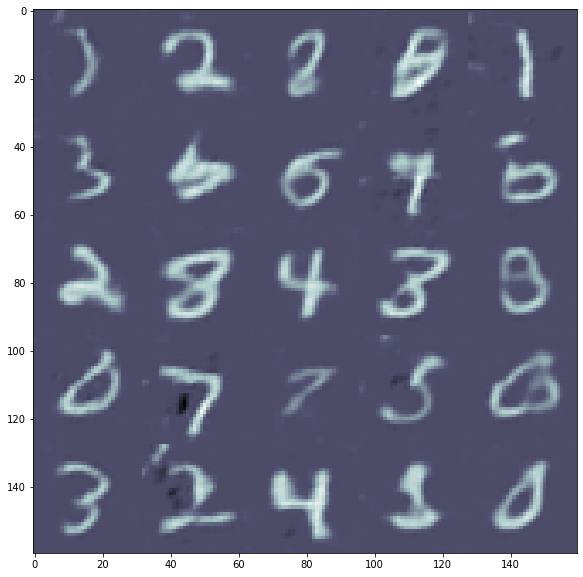

In [8]:
plot_model_state(samples, 0)
plt.savefig('../figures2/trained_random_generated.png')

# T-SNE visualisation

In [9]:
def get_tsne_embeds(latent):
    return TSNE(n_components=2).fit_transform(latent.cpu().detach().numpy())

In [10]:
with torch.no_grad():
    data_train = mnist_train_data.data.reshape(60000,1,28,28).float().to(device)
    labels_train = mnist_train_data.targets

    mu_train, logvar_train = model.encode(data_train)
    z_train = model.reparameterize(mu_train, logvar_train)

    data = mnist_test_data.data.reshape(10000,1,28,28).float().to(device)
    labels = mnist_test_data.targets

    mu, logvar = model.encode(data)
    z = model.reparameterize(mu, logvar)

In [ ]:
tsne_embeds = get_tsne_embeds(z)

In [ ]:
_, X_test, _, y_test = train_test_split(tsne_embeds, labels, \
                                        test_size=0.3, random_state=42, shuffle=True, stratify=labels)

In [ ]:
uq = np.unique(y_test, return_counts=True)[0]

In [ ]:
scatter = plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test,cmap=plt.cm.gist_rainbow)
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1,2,3,4,5,6,7,8,9])
plt.title('t-SNE Representation of the latent embeddings')
plt.savefig('../figures2/latent_tsne.png')
plt.show()

# Training on Latent Embeddings

In [ ]:
clf = SVC()
clf.fit(z_train.cpu().detach().numpy(), labels_train)

In [ ]:
y_pred=clf.predict(z.cpu().detach().numpy())

In [ ]:
print(classification_report(labels, y_pred))

In [ ]:
plot_confusion_matrix(clf, z.cpu().detach().numpy(), labels,cmap=plt.cm.Blues,normalize='true')
plt.title('Confusion Matrix for the latent representation classficiation')
plt.savefig('../figures2/latent_confusion_matrix.png')
plt.show()